In [1]:
%load_ext autoreload
%autoreload 2

from src.util import get_path
get_path()

include_pre_2021_data = False

C:/Users/jy/AppData/Local/bipy/31094803/projects/57754191e2d34b7296075e94c545cc4d


In [2]:
try:
    import bql
    import sys

    sys.path.append('./Lib')
    from etiqalib import *
    from etiqalib.config import *
    from etiqalib.bqfields import BaseGetData
    from datetime import datetime

    read = False

    bq = bql.Service()
    def px_function(bq, ticker, start, end):
        bqapi = BaseGetData(bq)
        dff = bqapi.get_data(ticker,{'px_last':bq.data.px_last(start=start, end=end, **fillprev)})
        return dff.drop('CURRENCY',1).dropna(subset=['px_last'])

    start_date = '1998-01-01'
    end_date = datetime.today().date().isoformat()

    if not read:
        opr_df = download_incremental(bq, 'MAOPRATE Index',px_function, start_date, end_date)
        srr_df = download_incremental(bq, 'MAOPSRR Index',px_function, start_date, end_date)
        m3_df = download_incremental(bq, 'MAMS3YOY Index',px_function, start_date, end_date)
        magy10yr = download_incremental(bq, 'MAGY10YR Index',px_function, start_date, end_date)
        price_df = download_incremental(bq, 'FBMKLCI Index', px_function, start_date, end_date)

        opr_df.to_csv('data/opr/opr_rate.csv')
        srr_df.to_csv('data/opr/srr_rate.csv')
        m3_df.to_csv('data/opr/m3_rate.csv')
        magy10yr.to_csv('data/opr/magy10yr.csv')
        price_df.to_csv('data/opr/fbmklci.csv')
        dt = opr_df["DATE"].max()
        print(f"Refreshed data: {dt}")
    else:
        opr_df = pd.read_csv('data/opr/opr_rate.csv', parse_dates=['DATE'])
        srr_df = pd.read_csv('data/opr/srr_rate.csv', parse_dates=['DATE'])
        m3_df = pd.read_csv('data/opr/m3_rate.csv', parse_dates=['DATE'])
        magy10yr = pd.read_csv('data/opr/magy10yr.csv', parse_dates=['DATE'])
        price_df = pd.read_csv('data/opr/fbmklci.csv', parse_dates=['DATE'])
except Exception as err:
    print("Running on local.")
    

Running on local.


In [3]:
raise_1 = False
try:
    import bql
    raise_1 = True
except:
    raise_1 = False
if raise_1:
    raise Exception("Query only in BQNT environment.")

In [4]:
from src.jinja_html import render_html, encode_graph
import weasyprint
import pandas as pd
from datetime import timedelta
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
from datetime import datetime
pd.set_option('display.max_columns', 50) 

import os

In [5]:
def get_year_month(df):  
    df['year_month'] = df['DATE'].map(lambda x: datetime(x.year, x.month, 1).date())
    return df

def filter_date(df,start_date, end_date, date_col='year_month'):
    return df.query('{dtcol} >= "{}" and {dtcol} <= "{}"'.format(start_date, end_date, dtcol=date_col))

def read_csv(file):
    '''
    with parse_date
    '''
    return pd.read_csv(file, parse_dates=['DATE'])

# os.listdir('data/Loans Stats/')

### Parameters

In [6]:
image_folder = 'output'

# dt = datetime(2022,8,1)
dt = datetime.now()

dt_mth = dt.strftime("%Y%m")
file_1 = f'data/Loans Stats/{dt_mth}_Banking System.XLS'
file_2 = f'data/Loans Stats/{dt_mth}_Banking System_2.XLS'

start_date = "2010-01-01"

opr_df         = read_csv('data/opr/opr_rate.csv')
end_date = opr_df["DATE"].max() - pd.offsets.BMonthEnd(1)
if include_pre_2021_data:
    ref_start_loan_date = pd.to_datetime("2010-01-01")
else:
    ref_start_loan_date = pd.to_datetime("2021-07-01")
ref_loan_date = opr_df["DATE"].max() - pd.offsets.BMonthEnd(2)
print("End Date:", end_date, "Loan Ref Date:", ref_loan_date)
print(dt_mth, file_1, file_2)

End Date: 2023-02-28 00:00:00 Loan Ref Date: 2023-01-31 00:00:00
202303 data/Loans Stats/202303_Banking System.XLS data/Loans Stats/202303_Banking System_2.XLS


### Read Data

In [7]:
loan_3_df        = pd.read_excel(file_1, sheet_name='Loan_3')
int_df           = pd.read_excel(file_1, sheet_name='Int')
npl_df           = pd.read_excel(file_1, sheet_name='NPL')[['Unnamed: 0','Unnamed: 17']]
# application_df = pd.read_excel(file_2, sheet_name='Applications by purpose', header=None)
# approval_df    = pd.read_excel(file_2, sheet_name='Approvals by purpose', header=None)

opr_df         = read_csv('data/opr/opr_rate.csv').pipe(get_year_month).pipe(filter_date, start_date, end_date, "DATE")
m3_price       = read_csv('data/opr/m3_rate.csv').pipe(get_year_month).pipe(filter_date, start_date, end_date, "DATE") 
srr            = read_csv('data/opr/srr_rate.csv').pipe(get_year_month).pipe(filter_date, start_date, end_date, "DATE")
bond_yields    = read_csv('data/opr/magy10yr.csv').pipe(filter_date, start_date, end_date, "DATE")

In [8]:
# !pip install xlrd --upgrade

### Data Processing

In [9]:
def trim_df(df):
    dff = df[list(range(15))].copy()
    dff.columns  = dff.iloc[3][:2].append(dff.iloc[2][2:]).tolist()
    dff = dff.iloc[4:].copy().dropna(subset=['Month'])
    dff['Year'] = dff['Year'].ffill()
    dff['year_month'] = dff.apply(lambda x: '{}-{}-01'.format(x['Year'], str(x['Month']).zfill(2)),1)
    return dff

def process_npl(npl):
    npl.columns= ['Date', 'Gross NPL']
    npl = npl.iloc[npl[npl['Date']=='Monthly'].index[0]+1:].dropna().copy()
    npl['Date'] = pd.to_datetime(npl['Date'])
    return npl

def process_opr(opr_df):
    def label(x):
        if x > 0:
            return 'hike'
        elif x< 0 :
            return 'cut'
        else:
            return 'stay'
    
    opr_df['label'] = opr_df['px_last'].diff().map(label) 
    opr_month = pd.pivot_table(opr_df, index='year_month', columns='label', values='px_last').fillna(0)\
                  .applymap(lambda x: 1 if x!= 0 else 0).reset_index()
    opr_month['label'] = opr_month.apply(lambda x: 'cut' if x['cut']==1 else ('hike' if x['hike'] == 1 else 'stay'), 1)
    return opr_df, opr_month

# application_df_1 = trim_df(application_df).pipe(filter_date, start_date, end_date)
# approval_df_1 = trim_df(approval_df).pipe(filter_date, start_date, end_date).\
#                                     rename(columns={'Residential':'Residential mortgages',
#                                                     'Non-residential':'Non-residential mortgages',
#                                                      'Consumer goods':'Consumer durable goods', 
#                                                     'Other ':'Other purpose'})
npl = process_npl(npl_df).pipe(filter_date, start_date, end_date, "Date")
opr_df, opr_month = process_opr(opr_df)

m3_price_m = m3_price.groupby(['ID','year_month'])['px_last'].last().reset_index()
srr_m = srr.groupby(['ID','year_month'])['px_last'].last().reset_index()

In [10]:
# Preprocess application_df
pd.set_option('display.max_rows', 50)

def load_clean_application_df(file_2):
    application_df = pd.read_excel(file_2, sheet_name='Applications by purpose', header=None)
    # approval_df    = pd.read_excel(file_2, sheet_name='Approvals by purpose', header=None)
    df = application_df.copy()
    dff = df[list(range(15))].copy()
    dff.columns  = dff.iloc[3][:2].append(dff.iloc[2][2:]).tolist()
    u1 = ~dff["Month"].isna()
    tdf = dff.loc[u1].iloc[1:].copy()
    tdf["year"] = tdf["Year"].replace({"New classification": None}).ffill().astype(int)
    tdf['Date'] = pd.to_datetime(tdf.apply(lambda x: '{}-{}-01'.format(x['year'], str(x['Month']).zfill(2)),1))
    tdf = tdf.set_index("Date").sort_index()
    application_df_1 = tdf.loc[ref_start_loan_date:ref_loan_date, :].drop(columns=["Year", "Month", "year"])
    return application_df_1

def load_clean_approval_df(file_2):
    approval_df = pd.read_excel(file_2, sheet_name='Approvals by purpose', header=None)
    df = approval_df.copy()
    dff = df[list(range(15))].copy()
    dff.columns  = dff.iloc[3][:2].append(dff.iloc[2][2:]).tolist()
    u1 = ~dff["Month"].isna()
    tdf = dff.loc[u1].iloc[1:].copy()
    tdf["year"] = tdf["Year"].replace({"New classification": None}).ffill().astype(int)
    tdf['Date'] = pd.to_datetime(tdf.apply(lambda x: '{}-{}-01'.format(x['year'], str(x['Month']).zfill(2)),1))
    tdf = tdf.set_index("Date").sort_index()
    approval_df_1 = tdf.loc[ref_start_loan_date:ref_loan_date, :].drop(columns=["Year", "Month", "year"])
    approval_df_1 = approval_df_1.rename(columns={'Residential':'Residential mortgages',
                                                    'Non-residential':'Non-residential mortgages',
                                                     'Consumer goods':'Consumer durable goods', 
                                                    'Other ':'Other purpose'})
    return approval_df_1


In [11]:
application_df_1 = load_clean_application_df(file_2)
approval_df_1 = load_clean_approval_df(file_2)

In [12]:
loan_last_date = npl["Date"].values[-1]
print(loan_last_date)


2023-01-01T00:00:00.000000000


### Visualization

In [13]:
width = 1200
height = 625

def add_title(fig, title, ylabel="Amount (billion) [MYR]"):
    fig.update_layout(template='ygridoff',
                      title=title,
                    yaxis=dict(
                    title=ylabel,
                ),
                )
    return fig


def plot_multi_lines(df, x_axis, y_axes):
    fig = go.Figure()
    for col in y_axes:
        fig.add_trace(go.Scatter(x=df[x_axis], y=df[col]/1000, name=col))
    fig.update_xaxes(dtick='M12')
    return fig


### Overview of Bank Loan Stats

In [14]:
def create_overview_fig(m3_price_m, srr_m, npl, opr_df):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x = npl['Date'],
                             y = npl['Gross NPL'],
                             marker_color='#7f7f7f',
                             name = 'NPL',
                            yaxis="y2"))

    fig.add_trace(go.Scatter(x = m3_price_m['year_month'],
                             y = m3_price_m['px_last'],
                             marker_color='#ff7f0e',
                             name = 'M3'),
                 )

    fig.add_trace(go.Scatter(x = srr_m['year_month'],
                             y = srr_m['px_last'],
                             marker_color='red',
                             name = 'SRR'),
                 )


    fig.add_trace(go.Scatter(x = opr_df['DATE'],
                             y = opr_df['px_last'],
                             marker_color='blue',
                             mode='lines',
                             name = 'OPR',
                             yaxis="y2"),
                 )

    fig.update_layout(
        title='NPL',
        yaxis=dict(
            title="M3 / SRR",
            titlefont=dict(
                color="red"
            ),
            tickfont=dict(
                color="red"
            )
        ),
        yaxis2=dict(
            title="Gross NPL / OPR",
            anchor="x",
            overlaying="y",
            side="right",
            position=0.85
        )
    )

    fig.update_layout(
        template='ygridoff',
        xaxis = dict(
            dtick = "M12"
        )
    )
    fig.update_layout(
        autosize=False,
        width=width,
        height=height,)
    return fig


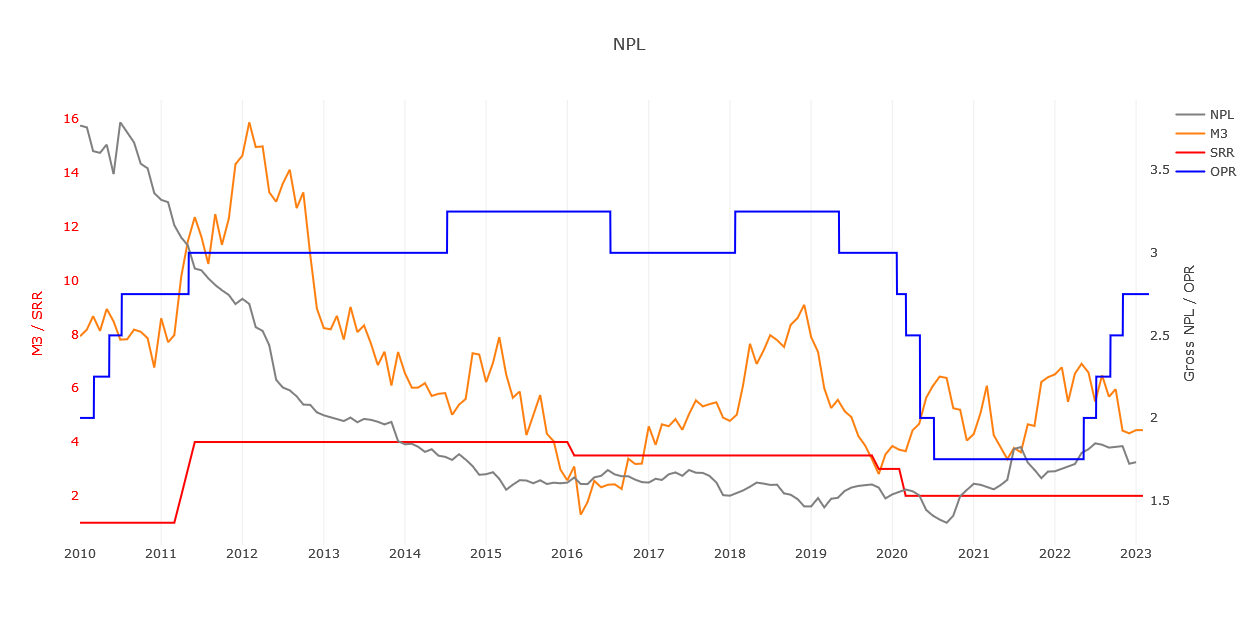

In [15]:
fig_overview = create_overview_fig(m3_price_m, srr_m, npl, opr_df)
fig_overview

In [16]:
x1 = m3_price_m.tail(13)
d1, d2 = x1.year_month.values[0], x1.year_month.values[-1]
m3_1, m3_2 = x1.loc[:, "px_last"].values[0], x1.loc[:, "px_last"].values[-1]

x1 = npl.tail(13)
d1, d2 = x1.Date.values[0], x1.Date.values[-1]
npl_1, npl_2 = x1.loc[:, "Gross NPL"].values[0], x1.loc[:, "Gross NPL"].values[-1]

if npl_2 >= npl_1:
    compare = "higher"
else:
    compare = "lower"
overview_text = "M3 YoY Growth is {:.2f}%. Non-performing Loan (NPL) is {:.2f}%, which is {} compared to last year ({:.2f}%)".format(m3_2, npl_2, compare, npl_1)
overview_text, npl_2, npl_1
# x1.loc[:, "Gross NPL"]

('M3 YoY Growth is 4.44%. Non-performing Loan (NPL) is 1.73%, which is higher compared to last year (1.68%)',
 1.7320752643399253,
 1.6767813224508938)

### Total Bank Loan Application and Approval

In [17]:
def create_loan_app_fig(application_df_1, approval_df_1, opr_df):
    appl_df = application_df_1.reset_index().copy()
    appr_df = approval_df_1.reset_index().copy()
    
    fig2 = go.Figure()
    
    fig2.add_trace(go.Scatter(x = appl_df['Date'],
                             y = appl_df['TOTAL']/1000,
                             marker_color='#ffcfcf',
                             name = 'Application'))
        
    fig2.add_trace(go.Scatter(x = appl_df['Date'],
                             y = appl_df['TOTAL'].rolling(12).mean()/1000,
                             marker_color='red',
                             name = 'Application (Avg)'))
    
    fig2.add_trace(go.Scatter(x = appr_df['Date'],
                             y = appr_df['TOTAL']/1000,
                             marker_color='#b6fac1',
                            name = 'Approval'),
                 )
    
    fig2.add_trace(go.Scatter(x = appr_df['Date'],
                             y = appr_df['TOTAL'].rolling(12).mean()/1000,
                             marker_color='green',
                            name = 'Approval (Avg)'),
                 )

    fig2.add_trace(go.Scatter(x = opr_df.query(f'DATE >= "{ref_start_loan_date}"')['DATE'],
                             y = opr_df.query(f'DATE >= "{ref_start_loan_date}"')['px_last'],
                             marker_color='blue',
                             mode='lines',
                             name = 'OPR',
                            yaxis="y2"),
                 )

    fig2.update_layout(
        title='Total Bank Loan Application and Approval (Rolling 12 Months Average)',
        yaxis=dict(
            title="Application / Approval  (billion) [MYR]",
            titlefont=dict(
                color="#7f7f7f"
            ),
            tickfont=dict(
                color="#7f7f7f"
            )
        ),
        yaxis2=dict(
            title="OPR",
            titlefont=dict(
                color="blue"
            ),
            tickfont=dict(
                color="blue"
            ),
            anchor="x",
            overlaying="y",
            side="right",
            position=0.85
        )
    )

    fig2.update_layout(
        template='ygridoff',
        xaxis = dict(
            dtick = "M12"
        )
    )
    fig2.update_layout(
        autosize=False,
        width=width,
        height=height,)
    return fig2

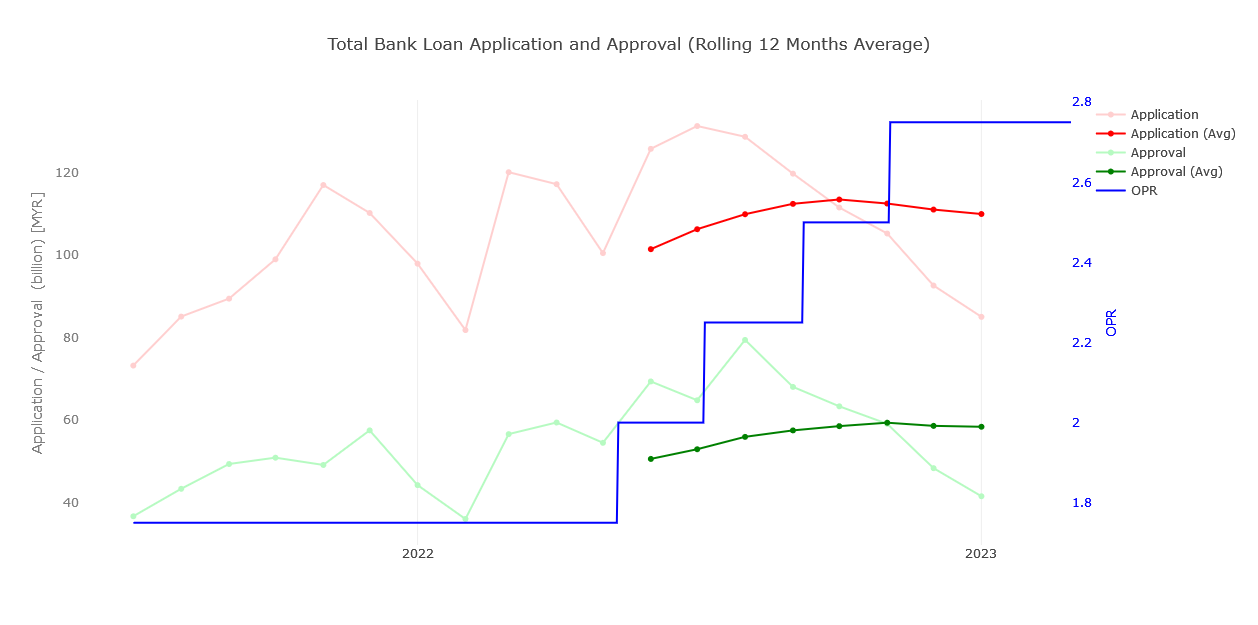

In [18]:
fig_loan = create_loan_app_fig(application_df_1, approval_df_1, opr_df)
fig_loan

In [19]:
x1 = application_df_1.tail(13)
appl_1, appl_2, appl_3 = x1.loc[:, "TOTAL"].values[0], x1.loc[:, "TOTAL"].values[-2], x1.loc[:, "TOTAL"].values[-1]
appl_yoy = appl_3/appl_1-1
appl_mom = appl_3/appl_2-1

x1 = approval_df_1.tail(13)
appr_1, appr_2, appr_3 = x1.loc[:, "TOTAL"].values[0], x1.loc[:, "TOTAL"].values[-2], x1.loc[:, "TOTAL"].values[-1]
appr_yoy = appr_3/appr_1-1
appr_mom = appr_3/appr_2-1

latest_month = x1.index[-1].strftime("%B %Y")
loan_text = "As of {}, Total Bank Loan Application MoM and YoY change are {:.2f}% and {:.2f}% respectively;".format(latest_month, appl_mom*100, appl_yoy*100)
loan_text += " Total Bank Loan Approval MoM and YoY change are {:.2f}% and {:.2f}% respectively.".format(appr_mom*100, appr_yoy*100)
loan_text

'As of January 2023, Total Bank Loan Application MoM and YoY change are -8.19% and -13.17% respectively; Total Bank Loan Approval MoM and YoY change are -14.08% and -6.10% respectively.'

In [20]:
appl_1, appl_2, appl_3

(97933.45765131994, 92626.49981623003, 85037.98102899002)

In [21]:

purposes = [i for i in application_df_1 if i not in ['Date', 'Year','Month','TOTAL','year_month','Auto','Consumer durable goods']]
application_df_1a = application_df_1[purposes]
application_df_2 = application_df_1a.rolling(12).mean()
approval_df_1a = approval_df_1[purposes]
approval_df_2 = approval_df_1a.rolling(12).mean()




### Loan App & Approval

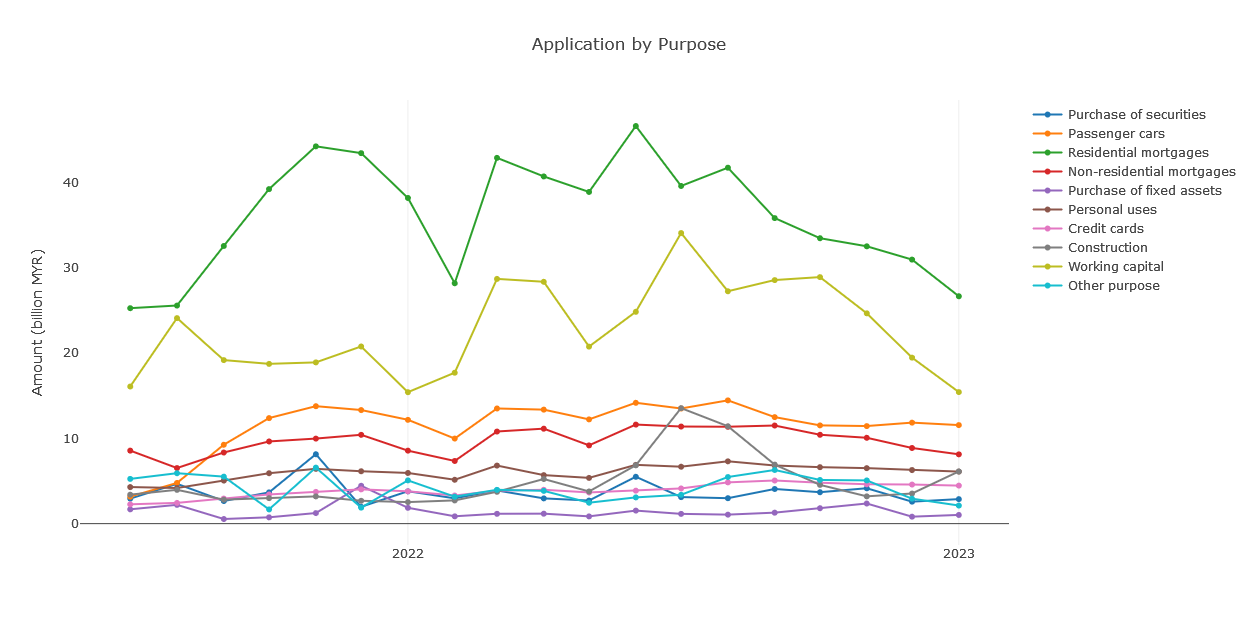

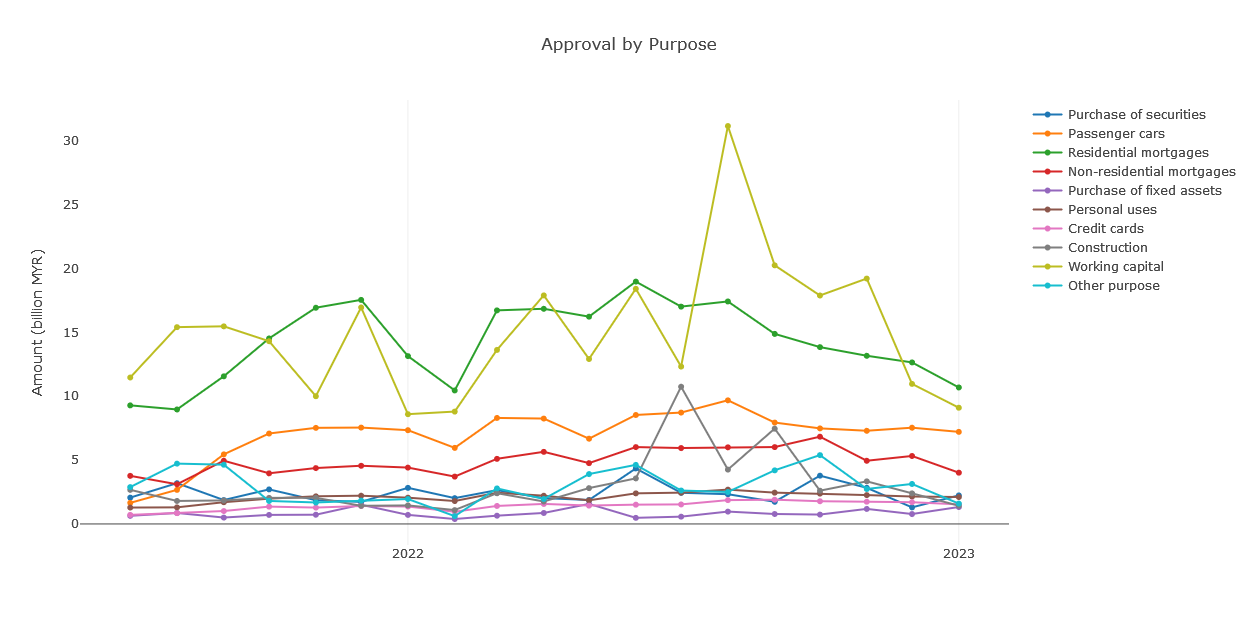

In [22]:
fig_application = plot_multi_lines(application_df_1a.reset_index(), 'Date', purposes)
fig_application = add_title(fig_application, 'Application by Purpose', ylabel = "Amount (billion MYR)")
fig_application = fig_application.update_layout(
    autosize=False,
    width=width,
    height=height,)

fig_approval = plot_multi_lines(approval_df_1a.reset_index(), 'Date', purposes)
fig_approval = add_title(fig_approval, 'Approval by Purpose', ylabel = "Amount (billion MYR)")
fig_approval = fig_approval.update_layout(
    autosize=False,
    width=width,
    height=height,)

display(fig_application)
display(fig_approval)


In [23]:
# a1 = approval_df_2.loc["2014", ["Residential mortgages"]]
# a2 = approval_df_2.loc["2022", ["Residential mortgages"]]
# pd.concat([a1, a2])

In [24]:
# application_df_1["Date"] = pd.to_datetime(application_df_1["year_month"])
# application_df_1a = application_df_1[purposes].set_index("Date")
# application_df_1a

In [25]:
def preproc_app_df(df):
    app_df_1 = df.pct_change(12).dropna().iloc[-4:]
    col_1 = app_df_1.T.columns[-1]
    new_col = [j.strftime("%b%y-YoY") for j in app_df_1.T.columns]
    table_application_1 = (  app_df_1.T.sort_values(col_1, ascending=False)*100).round(2)
    table_application_1.columns = new_col
    return table_application_1

def create_styled_table(app_df):
    app_df_1 = app_df.copy()
    app_df_1.index.name = "Purpose"
    app_df_2 = app_df_1.reset_index()
    idxs = app_df_2.index[app_df_2["Purpose"].isin(["Working capital", "Credit cards", "Residential mortgages", "Passenger cars"])]

    fdf_styled = app_df_2.style.set_properties(**{
        "text-align": "right",
        'font-size': '8pt',
        'white-space': 'pre-wrap',
    })
    cols = fdf_styled.columns
    bd_color = "#acacad"
    props = {
        col: {"padding": "3px",  "text-align": "right", 'border-right': f'2px solid {bd_color}'}
        for col in cols
    }
    fdf_styled = fdf_styled.format(
        precision=2, subset=cols)

    for key, val in props.items():
        fdf_styled = fdf_styled.set_properties(subset=[key], **val)

    fdf_styled = fdf_styled.set_table_styles(
        [
            {
                "selector": ".row_heading, .blank", "props": [
                    ("display", "none;"),
                    # ('border-bottom', '2px solid #e3987b')
                ]
            },
            {'selector': 'th', 'props': [
                ('font-size', '8pt'),
                ('text-align', 'right'),
                ('max-width', '35px'),
                ('border-bottom', '3px solid #acacad')
            ]}
        ]
    )
    idx = pd.IndexSlice
    fdf_styled = fdf_styled.set_properties(**{"background-color": "#d4e1ff"}, subset=idx[idxs,:])
    return fdf_styled


In [26]:
appl_df_1 = preproc_app_df(application_df_1a)
appr_df_1 = preproc_app_df(approval_df_1a)
appl_df_2 = create_styled_table(appl_df_1)
appr_df_2 = create_styled_table(appr_df_1)

display(appl_df_2)
display(appr_df_2)

---
### Top 3 sectors

In [27]:
# lowest = application_df_1.query('Year == 2020').query('Month == 4').index[0]
# latest = application_df_1.index[-1]
# window = int(latest-lowest)
# print(window, type(window))

# top_3_recoveries = application_df_1[purposes].diff(window).iloc[-1].sort_values(ascending=False)[:3].index
# top_3_recoveries

In [28]:
def plot_multi_lines_2(df, x_axis, y_axes):
    colors = ["rgb(252, 32, 3)", "rgb(255, 172, 161, 0.5)", "rgb(0, 176, 88)", "rgb(149, 240, 194, 0.5)"]
    opacitys = [1, 0.5, 1, 0.5]
    fig = go.Figure()
    for col, color, opacity in zip(y_axes, colors, opacitys):
        fig.add_trace(go.Scatter(x=df[x_axis], y=df[col]/1000, name=col, 
                                 line=dict(
                                     # opacity=opacity,
                                     color=color
                                 )
                                )
                     )
    fig.update_xaxes(dtick='M12')
    return fig

def appl_vs_approv(col, smooth=True):
    appl_df = application_df_1.reset_index().copy()
    appr_df = approval_df_1.reset_index().copy()
    p_df = appl_df[['Date',col]].rename(columns={col:'Application'})\
                        .merge(appr_df[['Date',col]].rename(columns={col:'Approval'})).copy()
    if smooth:
        p_df['Application (Avg)'] = p_df['Application'].rolling(12).mean()
        p_df['Approval (Avg)'] = p_df['Approval'].rolling(12).mean()
    fig = plot_multi_lines_2(p_df, 'Date', ['Application (Avg)', 'Application','Approval (Avg)', 'Approval'])
    fig = add_title(fig, col + " (Rolling 12 Months Average)")
    return fig

def create_loan_fig(col, dts_1, dts_2):
    fig6a = appl_vs_approv(col)

    fillcolor = "#a7becf"
    layer = "below"
    dt1, dt2 = dts_1
    dt1b, dt2b = dts_2
#     fig6a.add_shape(type="rect",
#                             xref="x",
#                             yref="paper",
#                             x0=dt1,
#                             y0=0,
#                             x1=dt2,
#                             y1=1,
#                             line=dict(color="rgba(0,0,0,0)",width=3,),
#                             fillcolor=fillcolor,
#                             layer=layer) 
#     fig6a.add_shape(type="rect",
#                             xref="x",
#                             yref="paper",
#                             x0=dt1b,
#                             y0=0,
#                             x1=dt2b,
#                             y1=1,
#                             line=dict(color="rgba(0,0,0,0)",width=3,),
#                             fillcolor=fillcolor,
#                             layer=layer) 
    fig = fig6a.update_layout(
        autosize=False,
        width=width,
        height=height,)
    return fig


In [29]:
app_cols = ["Passenger cars", "Residential mortgages", "Credit cards", "Working capital"]
app_cols_2 = ["Passenger Cars", "Residential Mortgages", "Credit cards", "Working Capital"]

dates_1 = [("2013-01-01", "2013-12-31"), ("2013-10-01", "2014-12-31"), ("2017-01-01", "2018-12-31"), ("2015-12-01", "2016-09-30")]
dates_2 = [("2021-01-01", "2022-01-31"), ("2021-01-01", "2022-01-31"), ("2021-01-01", "2022-01-31"), ("2020-02-01", "2020-12-31")]

In [30]:
figs = []
for col, dts_1, dts_2 in zip(app_cols, dates_1, dates_2):
    fig_ = create_loan_fig(col, dts_1, dts_2)
    figs.append(fig_)


In [31]:
purpose_texts = []
for col in app_cols:
    v1 = appl_df_1.loc[col, :][-1]
    v2 = appr_df_1.loc[col, :][-1]
    txt = "{} Application YoY Change is {:.2f}%, Approval YoY Change is {:.2f}%".format(col, v1, v2)
    purpose_texts.append(txt)


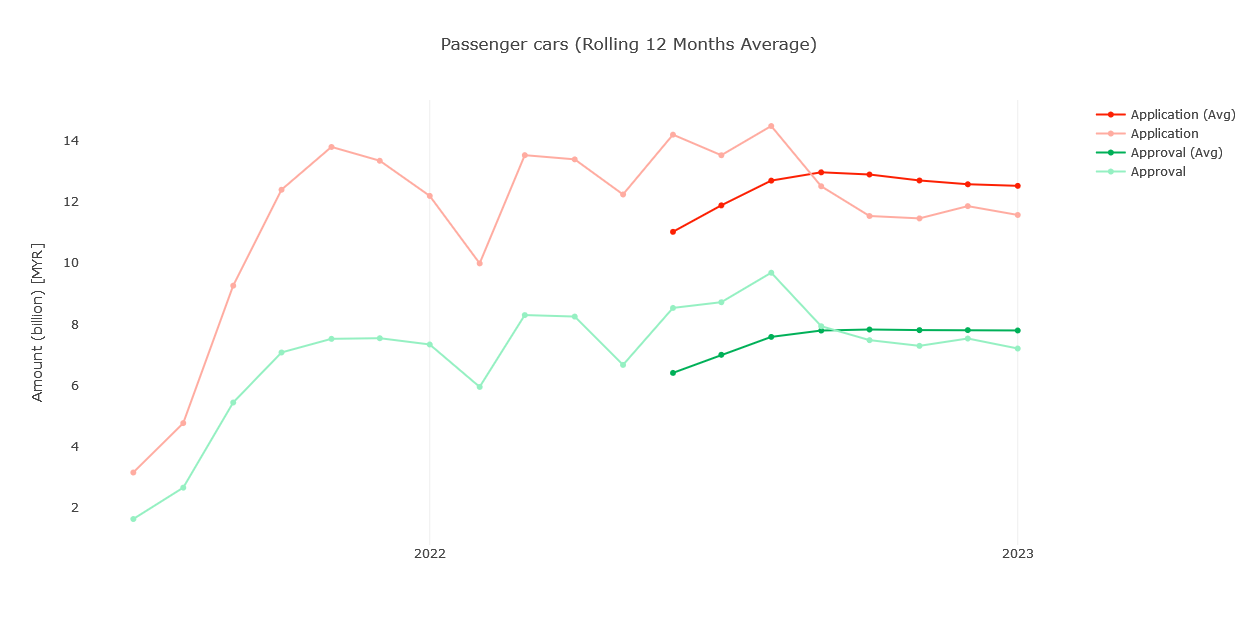

Passenger cars Application YoY Change is -5.10%, Approval YoY Change is -1.79%


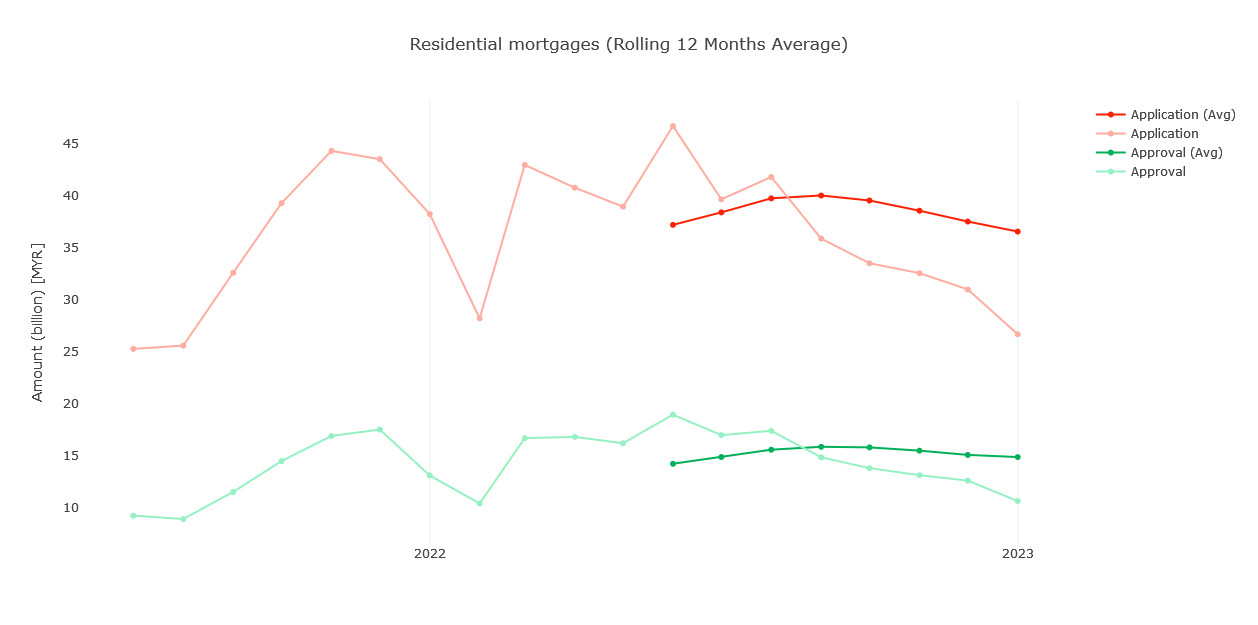

Residential mortgages Application YoY Change is -30.17%, Approval YoY Change is -18.69%


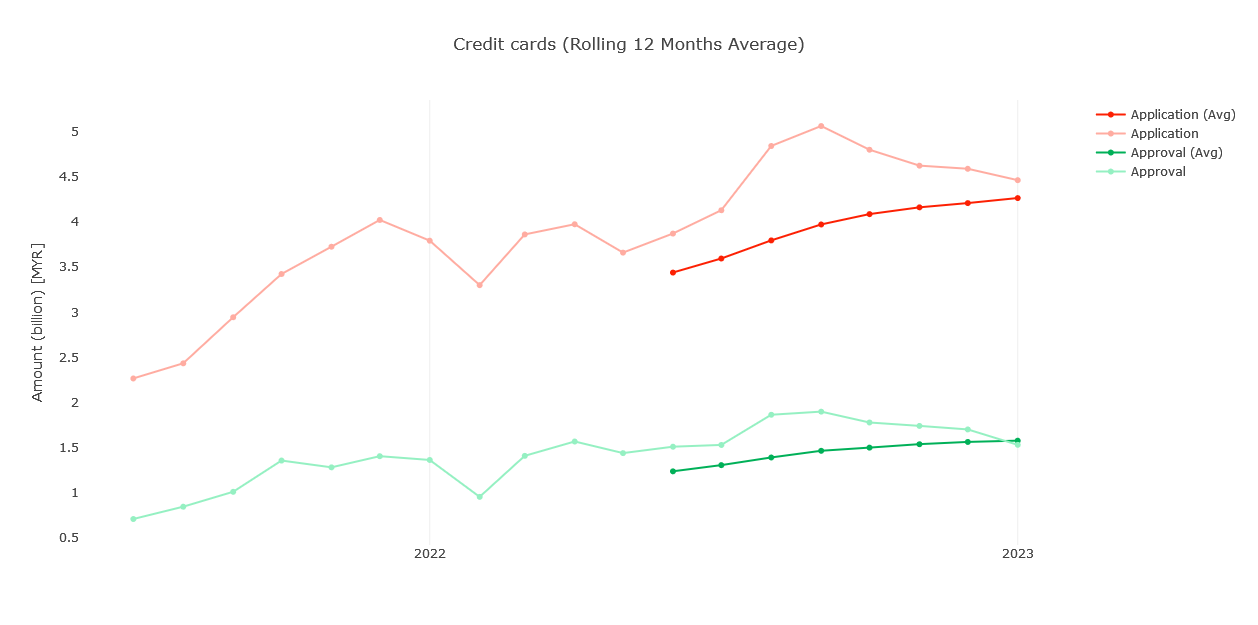

Credit cards Application YoY Change is 17.66%, Approval YoY Change is 12.29%


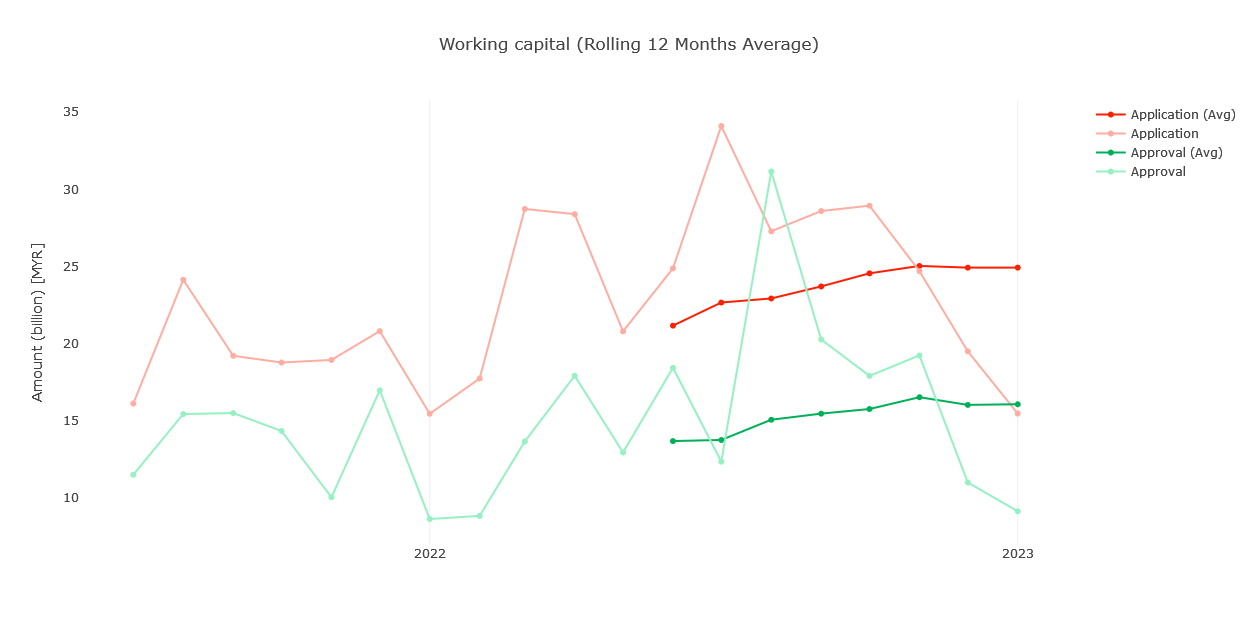

Working capital Application YoY Change is 0.10%, Approval YoY Change is 5.88%


In [32]:
for fig_, txt in zip(figs, purpose_texts):
    display(fig_)
    print(txt)
    

In [33]:
# appl_df_1

In [34]:
# purpose_texts

### Commentary

In [35]:

commentary = f"""
*Banking Loan Stats Update (Data as of end of {latest_month}):*

We are seeing decrease in loan application and approval after 4 OPR hikes prior to end of December 2022. 
The latest data point implied weakness in credit spending, which is in line with BNM decision to maintain the OPR at 2.75% in the latest Monetary Policy Committee (MPC) meeting.

Loan application and approval *MoM* growth are *{appl_mom:.2%}* and *{appr_mom:.2%}*, respectively. 
While, loan application and approval *YoY* growth are *{appl_yoy:.2%}* and *{appr_yoy:.2%}*, respectively.

Notable sectors in the credit market:
1) Credit Cards (YoY growth - application: *{appl_df_1.loc['Credit cards', :][-1]:.2f}%*, approval: *{appr_df_1.loc['Credit cards', :][-1]:.2f}%*)
2) Passenger Cars (YoY growth - application: *{appl_df_1.loc['Passenger cars', :][-1]:.2f}%*, approval: *{appr_df_1.loc['Passenger cars', :][-1]:.2f}%*)
3) Working Capital (YoY growth - application: *{appl_df_1.loc['Working capital', :][-1]:.2f}%*, approval: *{appr_df_1.loc['Working capital', :][-1]:.2f}%*)
4) Residential Mortgages (YoY growth - application: *{appl_df_1.loc['Residential mortgages', :][-1]:.2f}%*, approval: *{appr_df_1.loc['Residential mortgages', :][-1]:.2f}%*)
"""

from IPython.display import display, Markdown, Latex
print(commentary)



*Banking Loan Stats Update (Data as of end of January 2023):*

We are seeing decrease in loan application and approval after 4 OPR hikes prior to end of December 2022. 
The latest data point implied weakness in credit spending, which is in line with BNM decision to maintain the OPR at 2.75% in the latest Monetary Policy Committee (MPC) meeting.

Loan application and approval *MoM* growth are *-8.19%* and *-14.08%*, respectively. 
While, loan application and approval *YoY* growth are *-13.17%* and *-6.10%*, respectively.

Notable sectors in the credit market:
1) Credit Cards (YoY growth - application: *17.66%*, approval: *12.29%*)
2) Passenger Cars (YoY growth - application: *-5.10%*, approval: *-1.79%*)
3) Working Capital (YoY growth - application: *0.10%*, approval: *5.88%*)
4) Residential Mortgages (YoY growth - application: *-30.17%*, approval: *-18.69%*)



### Generate PDF

In [36]:
%%time
dt = pd.to_datetime(loan_last_date)
date_filename = dt.strftime("%Y-%m-%d")
date_time = dt.strftime("%B %Y")

title = "Bank Loan Stats"
data = {
    "title": title,
    "date_time_str": f"{date_time} Update",
    "fig_overview": encode_graph(fig_overview),
    "overview_text": overview_text,
    "fig_loan": encode_graph(fig_loan),
    "loan_text": loan_text,
    "fig_application": encode_graph(fig_application),
    "fig_approval": encode_graph(fig_approval),
    "appl_df_2": appl_df_2.to_html(),
    "appr_df_2": appr_df_2.to_html(),
    "fig_titles": app_cols_2,
    "figs": [encode_graph(fig) for fig in figs],
    "purpose_texts": purpose_texts, 
    "figs_N": len(figs),
}

output_html_filename = f"output/{title}-{date_filename}.html"
output_pdf_filename = f"output/{title}-{date_filename}.pdf"
render_html(data, output_filename=output_html_filename,
            input_template_filename="output/bank_loan_stats_template.html")
print('Rendered HTML.')
os.add_dll_directory(r"C:\Program Files\GTK3-Runtime Win64\bin")
doc_1 = weasyprint.HTML(filename=output_html_filename)
doc_pdf = doc_1.write_pdf(output_pdf_filename)
print('Rendered PDF.')


Rendered HTML.
Rendered PDF.
Wall time: 6.1 s


In [37]:
print("Done output:", output_pdf_filename)

Done output: output/Bank Loan Stats-2023-01-01.pdf
